# Group Work Project 3

Import packages.

Prepare portfolio used in previous gwp.

In [1]:
#!pip install yfinance --quiet
!pip install pyportfolioopt --quiet

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import cvxpy as cp

plt.style.use("seaborn-v0_8")

In [3]:
#  Downloading adjusted close prices for our stocks
tickers = ["AAPL", "NVDA", "TSLA", "XOM", "REGN", "LLY", "JPM", "META", "GOOG", "AMD"]
df_data = yf.download(tickers, start="2024-01-01", end="2025-06-30", auto_adjust=False)["Close"]

[*********************100%***********************]  10 of 10 completed


In [4]:
df_data.head()

Ticker,AAPL,AMD,GOOG,JPM,LLY,META,NVDA,REGN,TSLA,XOM
Date,,,,,,,,,,
2024-01-02,185.639999,138.580002,139.559998,172.080002,592.200012,346.290009,48.167999,905.000000,248.419998,102.360001
2024-01-03,184.250000,135.320007,140.360001,171.330002,617.700012,344.470001,47.569000,917.559998,238.449997,103.220001
2024-01-04,181.910004,136.009995,138.039993,171.410004,614.500000,347.119995,47.998001,912.169983,237.929993,102.320000
2024-01-05,181.179993,138.580002,137.389999,172.270004,618.549988,351.950012,49.097000,913.169983,237.490005,102.629997
2024-01-08,185.559998,146.179993,140.529999,172.020004,626.030029,358.660004,52.252998,902.880005,240.449997,100.919998


In [5]:
df_data.shape

(373, 10)

Calculating asset  annualized return volatilities

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np

# Downloading adjusted close prices for our stocks
tickers = ["AAPL", "NVDA", "TSLA", "XOM", "REGN", "LLY", "JPM", "META", "GOOG", "AMD"]
df_data = yf.download(tickers, start="2024-01-01", end="2025-06-30", auto_adjust=False)["Close"]

# Calculate daily returns
returns = df_data.pct_change().dropna()

# Calculate volatilities (annualized standard deviation)
# Using 252 trading days per year for annualization
volatilities = returns.std() * np.sqrt(252)

# Convert to percentage and display nicely
volatilities_pct = volatilities * 100

print("Annualized Volatilities (%):")
print("=" * 30)
for ticker, vol in volatilities_pct.items():
    print(f"{ticker}: {vol:.2f}%")

# Create a sorted DataFrame for better visualization
vol_df = pd.DataFrame({
    'Ticker': volatilities_pct.index,
    'Volatility (%)': volatilities_pct.values
}).sort_values('Volatility (%)', ascending=False)

print("\n" + "=" * 40)
print("Annual Volatilities Ranked (Highest to Lowest):")
print("=" * 40)
for _, row in vol_df.iterrows():
    print(f"{row['Ticker']}: {row['Volatility (%)']:.2f}%")

# Additional statistics
print("\n" + "=" * 40)
print("Volatility Statistics:")
print("=" * 40)
print(f"Highest volatility: {volatilities_pct.max():.2f}% ({volatilities_pct.idxmax()})")
print(f"Lowest volatility: {volatilities_pct.min():.2f}% ({volatilities_pct.idxmin()})")
print(f"Average volatility: {volatilities_pct.mean():.2f}%")
print(f"Median volatility: {volatilities_pct.median():.2f}%")

[*********************100%***********************]  10 of 10 completed

Annualized Volatilities (%):
AAPL: 29.77%
AMD: 52.20%
GOOG: 30.57%
JPM: 25.65%
LLY: 35.28%
META: 38.86%
NVDA: 56.13%
REGN: 32.52%
TSLA: 68.39%
XOM: 22.40%

Annual Volatilities Ranked (Highest to Lowest):
TSLA: 68.39%
NVDA: 56.13%
AMD: 52.20%
META: 38.86%
LLY: 35.28%
REGN: 32.52%
GOOG: 30.57%
AAPL: 29.77%
JPM: 25.65%
XOM: 22.40%

Volatility Statistics:
Highest volatility: 68.39% (TSLA)
Lowest volatility: 22.40% (XOM)
Average volatility: 39.18%
Median volatility: 33.90%


Calculating asset daily volatilities

In [7]:
# Daily volatilities
daily_volatilities = returns.std() * 100
vol=daily_volatilities.sort_values(ascending=False)

print("\nDaily Volatilities (%):")
print("=" * 25)
for ticker, vol in vol.items():
    print(f"{ticker}: {vol:.2f}%")


Daily Volatilities (%):
TSLA: 4.31%
NVDA: 3.54%
AMD: 3.29%
META: 2.45%
LLY: 2.22%
REGN: 2.05%
GOOG: 1.93%
AAPL: 1.88%
JPM: 1.62%
XOM: 1.41%


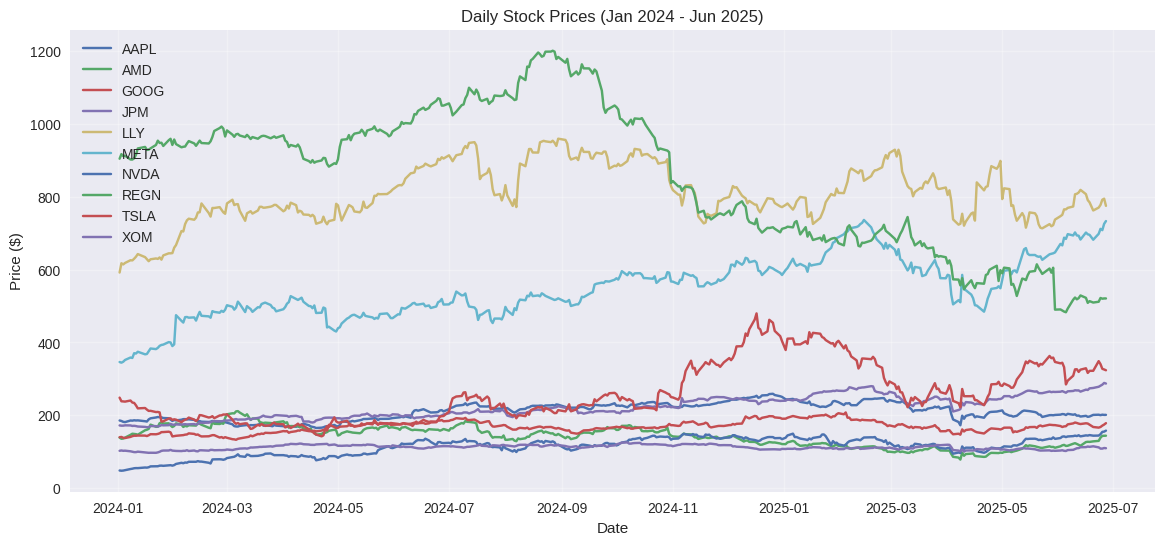

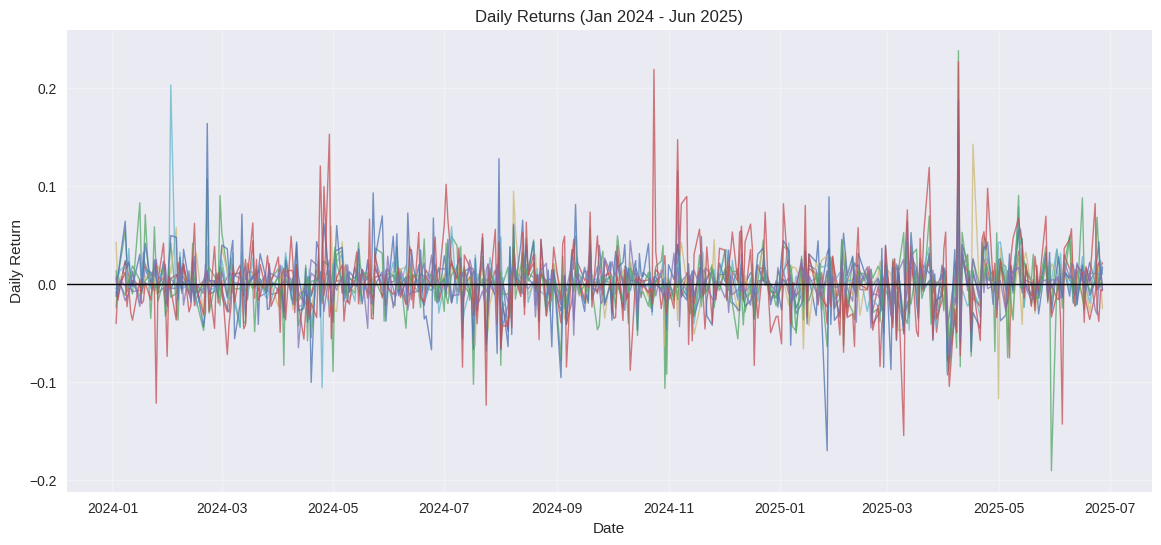

In [8]:
# Ensure timeline is aligned
df_prices = df_data.copy()
df_returns = returns.copy()

# === Daily Price Chart ===
plt.figure(figsize=(14, 6))
for col in df_prices.columns:
    plt.plot(df_prices.index, df_prices[col], label=col)

plt.title("Daily Stock Prices (Jan 2024 - Jun 2025)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.show()

# === Daily Returns Chart ===
plt.figure(figsize=(14, 6))
for col in df_returns.columns:
    plt.plot(df_returns.index, df_returns[col], alpha=0.75, linewidth=1)

plt.axhline(0, color='black', linewidth=1)
plt.title("Daily Returns (Jan 2024 - Jun 2025)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.grid(True, alpha=0.3)
plt.show()


### Step 1

We want to find the optimal portfolio given the following constraints:

* no short selling
* max 15% per asset
* fully invested

Objective function: maximize sharpe ratio

Baseline: Mean-Variance Optimization

In [9]:
# Compute daily log returns
daily_returns = np.log(df_data / df_data.shift(1)).dropna()

# Estimate mean vector and covariance matrix
mu = daily_returns.mean().values  # expected daily returns (sample mean)
Sigma = daily_returns.cov().values  # sample covariance matrix

n = len(tickers)

# Define cvxpy variables and parameters
w = cp.Variable(n)

# risk-aversion parameter: higher = more risk-averse
lambda_risk = 5.0

# Run sensitivity analysis on lambda
lambda_values = [1, 3, 5, 10, 20]
results = []
weight_results = {}

ann_factor = 252

for lam in lambda_values:
    w = cp.Variable(n)

    objective = cp.Maximize(mu @ w - lam * cp.quad_form(w, Sigma))
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        w <= 0.15
    ]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)

    w_opt = np.array(w.value).flatten()
    weight_results[lam] = w_opt # store weights for this lambda

    port_rets = daily_returns @ w_opt

    ann_return = port_rets.mean() * ann_factor
    ann_vol = port_rets.std(ddof=1) * np.sqrt(ann_factor)
    sharpe = ann_return / ann_vol

    num_nonzero = (w_opt > 1e-4).sum()
    num_capped = (w_opt >= 0.15 - 1e-4).sum()

    results.append({
        'lambda': lam,
        'ann_return': ann_return,
        'ann_vol': ann_vol,
        'sharpe': sharpe,
        'num_nonzero': num_nonzero,
        'num_capped': num_capped
    })

results_df = pd.DataFrame(results)
display(results_df)

# Select best lambda (by Sharpe)
best_row = results_df.loc[results_df["sharpe"].idxmax()]
best_lambda = best_row["lambda"]
print(f"\nBest lambda (by Sharpe ratio): {best_lambda}")

best_weights = weight_results[best_lambda]
opt_weights_series = pd.Series(best_weights, index=tickers)

# --- In-Sample Performance (already have port_rets but recompute for clarity)

best_w = opt_weights_series.values

in_sample_rets = daily_returns @ best_w
ann_return_in  = in_sample_rets.mean() * ann_factor
ann_vol_in     = in_sample_rets.std(ddof=1) * np.sqrt(ann_factor)
sharpe_in      = ann_return_in / ann_vol_in

print("=== In-Sample Performance (Jan 2024 - Jun 2025) ===")
print(f"Lambda*: {best_lambda}")
print(f"Annualized Return:     {ann_return_in:.2%}")
print(f"Annualized Volatility:  {ann_vol_in:.2%}")
print(f"Sharpe Ratio:          {sharpe_in:.2f}")

# ---------------------------------------------------------
# --- Out-of-Sample Performance (Jul 2025 - Jul 2025) ---
# ---------------------------------------------------------

# Download OOS period data
df_oos = yf.download(tickers, start="2025-07-01", end="2025-07-31", auto_adjust=False)["Close"]
oos_returns = df_oos.pct_change().dropna()

if len(oos_returns) == 0:
    print("\n Warning: No OOS returns available (check market trading days).")
else:
    # Compute portfolio returns using same weights
    oos_port_rets = oos_returns @ best_w

    # Because out-of-sample is only 1 month → annualize properly
    ann_return_oos = oos_port_rets.mean() * ann_factor
    ann_vol_oos    = oos_port_rets.std(ddof=1) * np.sqrt(ann_factor)
    sharpe_oos     = ann_return_oos / ann_vol_oos

    print("\n=== Out-of-Sample Performance (Jul 2025) ===")
    print(f"Annualized Return:     {ann_return_oos:.2%}")
    print(f"Annualized Volatility: {ann_vol_oos:.2%}")
    print(f"Sharpe Ratio:          {sharpe_oos:.2f}")





,lambda,ann_return,ann_vol,sharpe,num_nonzero,num_capped
0,1,0.323535,0.237764,1.360741,8,6
1,3,0.313282,0.220639,1.419883,7,6
2,5,0.313272,0.220636,1.419859,7,6
3,10,0.275668,0.209889,1.313401,7,6
4,20,0.173047,0.191046,0.905791,8,5


[                       0%                       ]


Best lambda (by Sharpe ratio): 3.0
=== In-Sample Performance (Jan 2024 - Jun 2025) ===
Lambda*: 3.0
Annualized Return:     31.33%
Annualized Volatility:  22.06%
Sharpe Ratio:          1.42


[*********************100%***********************]  10 of 10 completed


=== Out-of-Sample Performance (Jul 2025) ===
Annualized Return:     53.65%
Annualized Volatility: 9.91%
Sharpe Ratio:          5.41


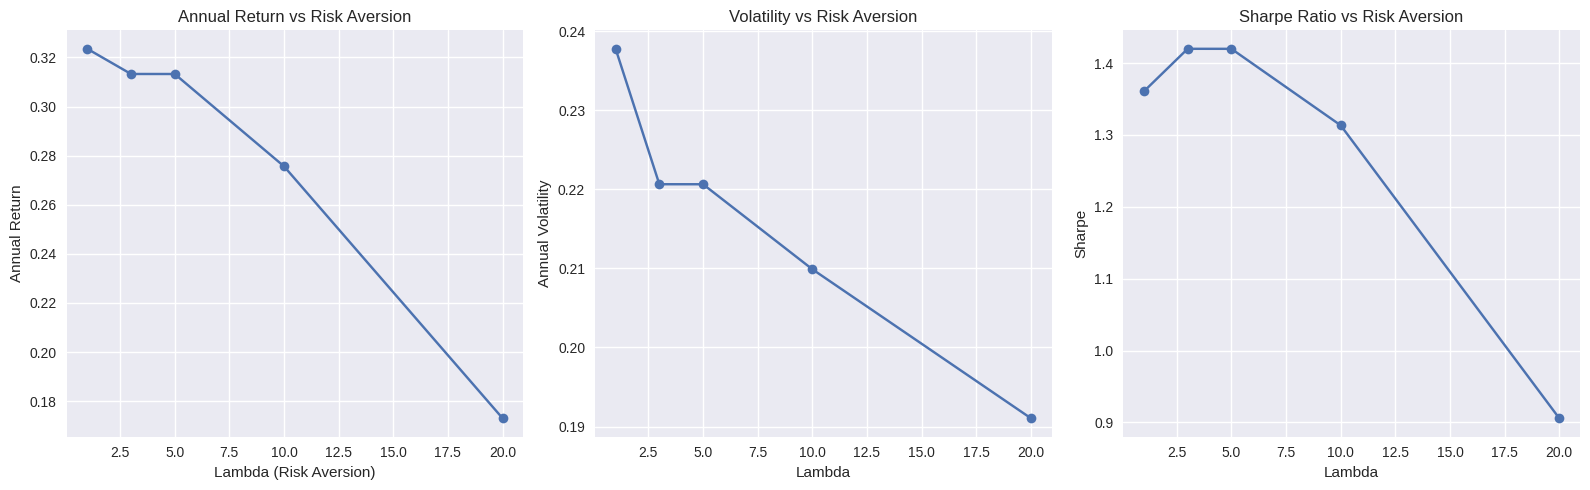

In [10]:
# Plotting performance of running sensitivity analysis for lambda
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(results_df['lambda'], results_df['ann_return'], marker='o')
ax[0].set_title("Annual Return vs Risk Aversion")
ax[0].set_xlabel("Lambda (Risk Aversion)")
ax[0].set_ylabel("Annual Return")

ax[1].plot(results_df['lambda'], results_df['ann_vol'], marker='o')
ax[1].set_title("Volatility vs Risk Aversion")
ax[1].set_xlabel("Lambda")
ax[1].set_ylabel("Annual Volatility")

ax[2].plot(results_df['lambda'], results_df['sharpe'], marker='o')
ax[2].set_title("Sharpe Ratio vs Risk Aversion")
ax[2].set_xlabel("Lambda")
ax[2].set_ylabel("Sharpe")

plt.tight_layout()
plt.show()


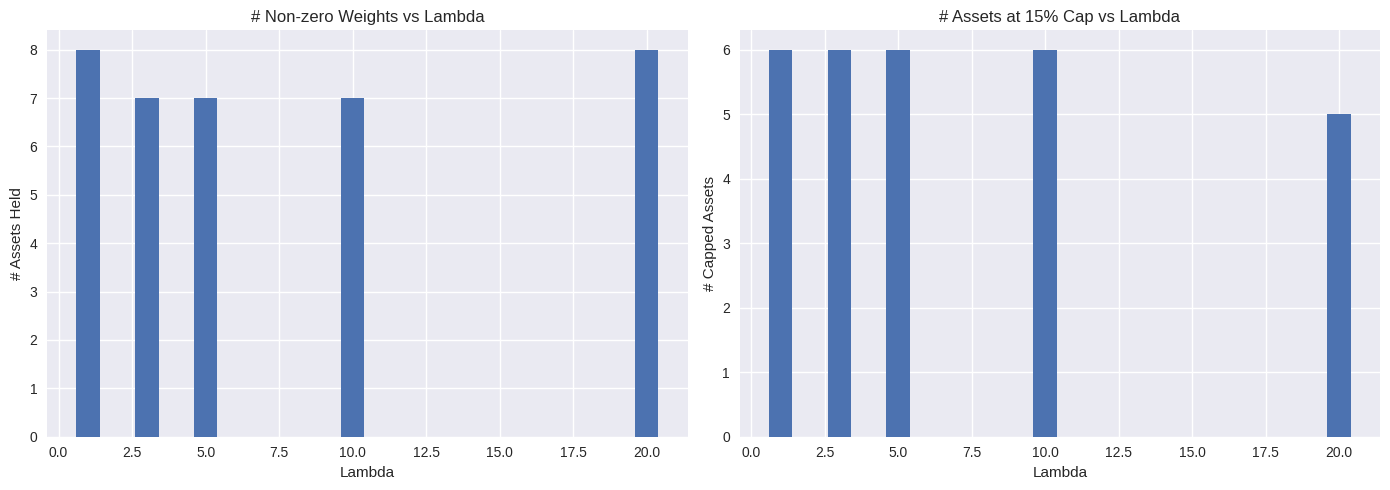

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].bar(results_df['lambda'], results_df['num_nonzero'])
ax[0].set_title("# Non-zero Weights vs Lambda")
ax[0].set_xlabel("Lambda")
ax[0].set_ylabel("# Assets Held")

ax[1].bar(results_df['lambda'], results_df['num_capped'])
ax[1].set_title("# Assets at 15% Cap vs Lambda")
ax[1].set_xlabel("Lambda")
ax[1].set_ylabel("# Capped Assets")

plt.tight_layout()
plt.show()


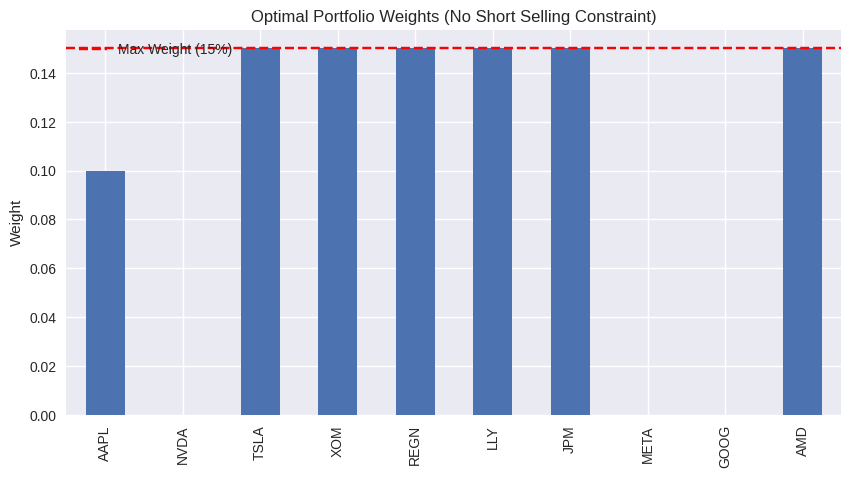

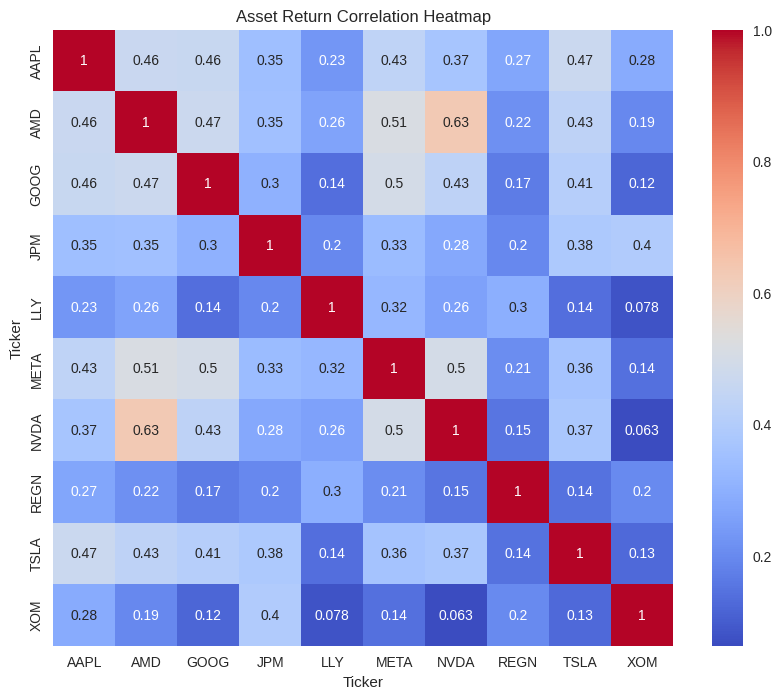

Number of assets included (non-zero weight): 7 / 10

Weight Distribution:


,0
AMD,0.150011
XOM,0.150011
TSLA,0.150011
REGN,0.150010
LLY,0.150010
JPM,0.150010
AAPL,0.099906
META,0.000011
GOOG,0.000010
NVDA,0.000010


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Weight Bar Chart ===
plt.figure(figsize=(10, 5))
opt_weights_series.plot(kind='bar')
plt.axhline(0.15, color='red', linestyle='--', label='Max Weight (15%)')
plt.title("Optimal Portfolio Weights (No Short Selling Constraint)")
plt.ylabel("Weight")
plt.legend()
plt.show()

# === Correlation Heatmap ===
plt.figure(figsize=(10, 8))
sns.heatmap(daily_returns.corr(), annot=True, cmap="coolwarm")
plt.title("Asset Return Correlation Heatmap")
plt.show()

# === Diversification stats ===
num_assets_nonzero = (opt_weights_series > 1e-2).sum()
print(f"Number of assets included (non-zero weight): {num_assets_nonzero} / {n}")
print("\nWeight Distribution:")
display(opt_weights_series.sort_values(ascending=False))


In [13]:
# creating a function to solve for MVO

def solve_mvo(mu, Sigma, lambda_risk=best_lambda, w_max=0.15):
    n = len(mu)
    w = cp.Variable(n)
    objective = cp.Maximize(mu @ w - lambda_risk * cp.quad_form(w, Sigma))
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        w <= w_max
    ]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)
    return np.array(w.value).flatten()

### Step 2 & 3

Improvements to baseline MVO using denoising

We apply denoising techniques:
* Ledoit-Wolf (LW)
* RBLW (via OAS)
* EPO (eigenvalue-based denoising / RMT-style)

In [14]:
from sklearn.covariance import LedoitWolf, OAS
import numpy as np
import pandas as pd

# daily_returns: T x n dataframe
T, n = daily_returns.shape

# Sample covariance (baseline)
Sigma_sample = np.cov(daily_returns.values, rowvar=False)


In [15]:
def cov_ledoit_wolf(returns: pd.DataFrame):
    """
    Ledoit-Wolf shrinkage covariance estimator.
    returns: DataFrame of shape (T, n)
    """
    lw = LedoitWolf().fit(returns.values)
    return lw.covariance_


In [16]:
def cov_rblw(returns: pd.DataFrame):
    """
    RBLW-style shrinkage using the OAS estimator,
    which is a Rao-Blackwellized Ledoit-Wolf in practice.
    """
    oas = OAS().fit(returns.values)
    return oas.covariance_


In [17]:
def cov_epo_rmt(Sigma: np.ndarray, T: int):
    """
    Eigenvalue-based covariance denoising (EPO-style):
    - Compute eigendecomposition of Sigma
    - Estimate noise bulk using RMT (Marchenko–Pastur upper edge)
    - Replace all 'noisy' eigenvalues with their average
    - Reconstruct cleaned covariance matrix
    """
    n = Sigma.shape[0]

    # Eigen-decomposition (covariance is symmetric PSD)
    eigvals, eigvecs = np.linalg.eigh(Sigma)

    # Aspect ratio q = T / N
    q = T / n

    # Estimate noise variance as average eigenvalue
    sigma2 = np.mean(eigvals)

    # Marchenko–Pastur upper edge (approx)
    lambda_plus = sigma2 * (1 + np.sqrt(1 / q))**2

    # Identify noisy eigenvalues (inside the bulk)
    noisy_idx = eigvals <= lambda_plus

    eigvals_clean = eigvals.copy()
    if noisy_idx.sum() > 0:
        avg_noisy = eigvals[noisy_idx].mean()
        eigvals_clean[noisy_idx] = avg_noisy

    # Rebuild covariance
    Sigma_clean = eigvecs @ np.diag(eigvals_clean) @ eigvecs.T

    return Sigma_clean


In [18]:
Sigma_lw   = cov_ledoit_wolf(daily_returns)
Sigma_rblw = cov_rblw(daily_returns)
Sigma_epo  = cov_epo_rmt(Sigma_sample, T)

cov_matrices = {
    "Sample": Sigma_sample,
    "Ledoit-Wolf": Sigma_lw,
    "RBLW": Sigma_rblw,
    "EPO": Sigma_epo
}


Test the denoising methods using out-of-sample period to measure estimation error.

In [53]:
import yfinance as yf

# Assumes you already have:
# - tickers
# - daily_returns (train: Jan 2024 – Jun 2025)
# - cov_matrices: {"Sample": Sigma_sample, "Ledoit-Wolf": Sigma_lw, "RBLW": Sigma_rblw, "EPO": Sigma_epo}

# Get out-of-sample data for July 2025
df_oos = yf.download(
    tickers,
    start="2025-07-01",
    end="2025-07-31",
    auto_adjust=False
)["Close"]

oos_returns = df_oos.pct_change().dropna()

print("OOS dates:", oos_returns.index.min(), "to", oos_returns.index.max())
print("Number of OOS trading days:", len(oos_returns))

# Out-of-sample (test) covariance as proxy for "true" covariance
Sigma_oos = np.cov(oos_returns.values, rowvar=False)


[*********************100%***********************]  10 of 10 completed

OOS dates: 2025-07-02 00:00:00 to 2025-07-30 00:00:00
Number of OOS trading days: 20


In [54]:
def cov_error_metrics(Sigma_hat: np.ndarray, Sigma_ref: np.ndarray):
    """
    Compare an estimated covariance Sigma_hat to a reference Sigma_ref.
    Returns:
    - Frobenius norm of the difference
    - Spectral (operator 2-) norm of the difference
    - MSE of diagonal elements (variances)
    """
    diff = Sigma_hat - Sigma_ref

    frob_error = np.linalg.norm(diff, "fro")
    spec_error = np.linalg.norm(diff, 2)  # largest singular value
    diag_mse   = np.mean((np.diag(Sigma_hat) - np.diag(Sigma_ref))**2)

    return frob_error, spec_error, diag_mse

rows = []

for name, Sigma_hat in cov_matrices.items():
    frob, spec, diag_mse = cov_error_metrics(Sigma_hat, Sigma_oos)
    cond_num = np.linalg.cond(Sigma_hat)
    rows.append({
        "Method": name,
        "Frobenius_Error": frob,
        "Spectral_Error": spec,
        "Diag_Var_MSE": diag_mse,
        "Condition_Number": cond_num
    })

error_df = pd.DataFrame(rows)
display(error_df.sort_values("Frobenius_Error"))


,Method,Frobenius_Error,Spectral_Error,Diag_Var_MSE,Condition_Number
1,Ledoit-Wolf,0.002469,0.002338,2.102207e-07,20.451687
2,RBLW,0.002553,0.002431,2.186917e-07,24.516314
0,Sample,0.002607,0.002488,2.253769e-07,27.202401
3,EPO,0.002626,0.002487,2.123985e-07,10.530876


In [55]:
# Diagonal variances for each method
var_sample = np.diag(Sigma_sample)
var_lw     = np.diag(Sigma_lw)
var_rblw   = np.diag(Sigma_rblw)
var_epo    = np.diag(Sigma_epo)
var_oos    = np.diag(Sigma_oos)

var_df = pd.DataFrame({
    "Ticker": daily_returns.columns,
    "OOS_Var": var_oos,
    "Sample_Var": var_sample,
    "LW_Var": var_lw,
    "RBLW_Var": var_rblw,
    "EPO_Var": var_epo
}).set_index("Ticker")

display(var_df)


,OOS_Var,Sample_Var,LW_Var,RBLW_Var,EPO_Var
Ticker,,,,,
AAPL,0.000080,0.000352,0.000373,0.000352,0.000432
AMD,0.000486,0.001079,0.001051,0.001051,0.001005
GOOG,0.000101,0.000370,0.000390,0.000376,0.000438
JPM,0.000131,0.000261,0.000287,0.000268,0.000366
LLY,0.000434,0.000493,0.000504,0.000495,0.000382
META,0.000111,0.000598,0.000602,0.000579,0.000561
NVDA,0.000225,0.001247,0.001207,0.001229,0.001157
REGN,0.000258,0.000419,0.000435,0.000449,0.000345
TSLA,0.001129,0.001852,0.001772,0.001785,0.001809


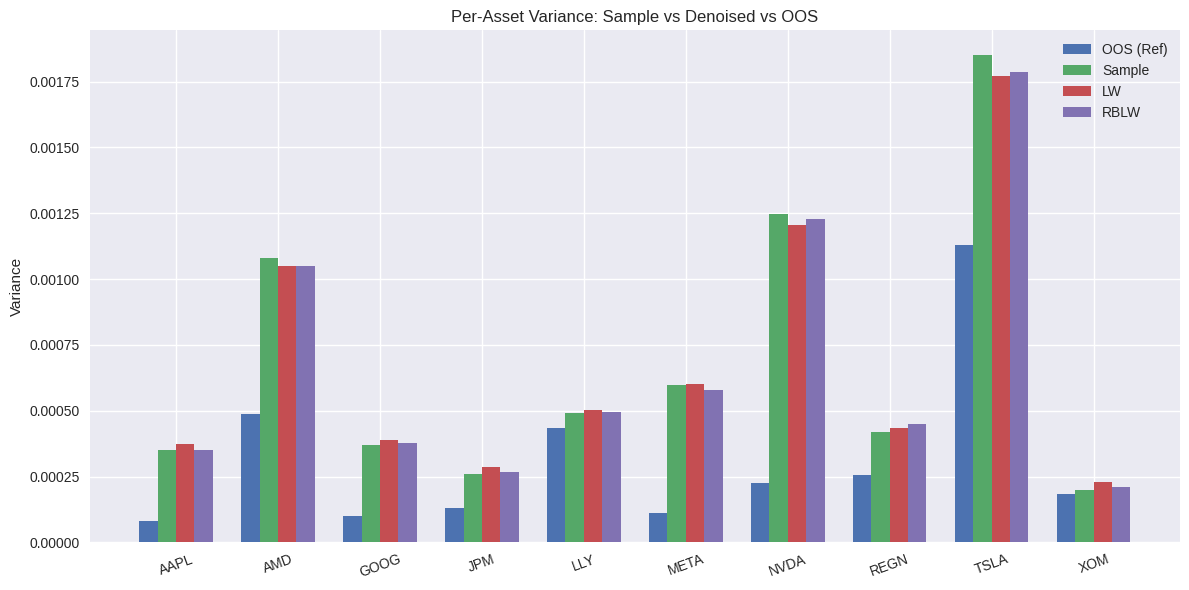

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
idx = np.arange(len(var_df.index))
bar_width = 0.18

plt.bar(idx - 1.5*bar_width, var_df["OOS_Var"],   width=bar_width, label="OOS (Ref)")
plt.bar(idx - 0.5*bar_width, var_df["Sample_Var"], width=bar_width, label="Sample")
plt.bar(idx + 0.5*bar_width, var_df["LW_Var"],     width=bar_width, label="LW")
plt.bar(idx + 1.5*bar_width, var_df["RBLW_Var"],  width=bar_width, label="RBLW")

plt.xticks(idx, var_df.index, rotation=20)
plt.ylabel("Variance")
plt.title("Per-Asset Variance: Sample vs Denoised vs OOS")
plt.legend()
plt.tight_layout()
plt.show()


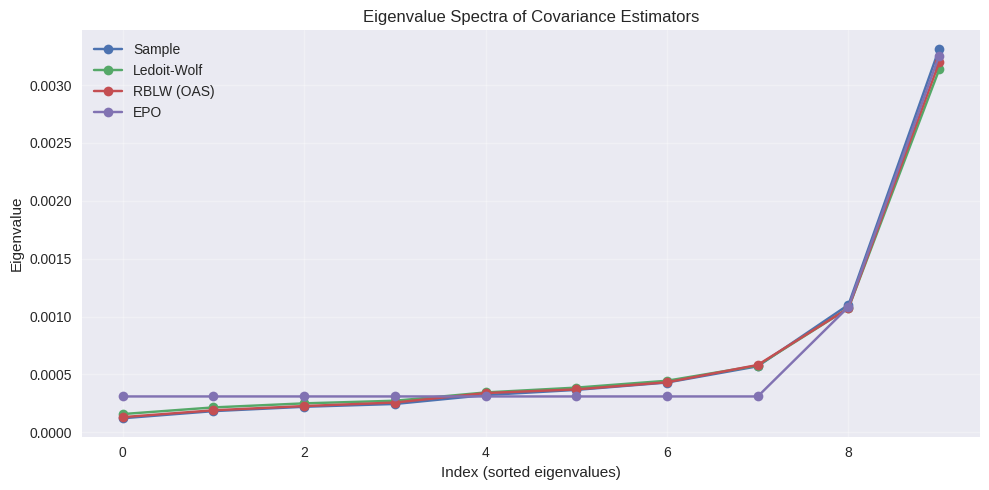

In [57]:
def eigen_spectrum(Sigma, label):
    eigvals = np.linalg.eigvalsh(Sigma)
    eigvals_sorted = np.sort(eigvals)
    plt.plot(eigvals_sorted, marker="o", label=label)

plt.figure(figsize=(10, 5))
eigen_spectrum(Sigma_sample, "Sample")
eigen_spectrum(Sigma_lw, "Ledoit-Wolf")
eigen_spectrum(Sigma_rblw, "RBLW (OAS)")
eigen_spectrum(Sigma_epo, "EPO")
plt.title("Eigenvalue Spectra of Covariance Estimators")
plt.xlabel("Index (sorted eigenvalues)")
plt.ylabel("Eigenvalue")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Improvements to baseline MVO using clustering

We using clustering methods to assist with diversifying. K-means or PAM

In [25]:
tickers        # list of your 10 tickers
daily_returns  # DataFrame: rows = dates, columns = tickers
!pip install scikit-learn-extra


In [26]:
# After running this cell, please restart the runtime (Runtime -> Restart runtime...)
# and then run all cells again, starting from the cell where scikit-learn-extra is installed.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids  # PAM

# ---------- Prepare feature matrix ----------
# Each asset is represented by its return time series
X_assets = daily_returns.values.T      # shape: (n_assets, T)
asset_names = daily_returns.columns    # tickers
n_assets = X_assets.shape[0]

# Standardize features across time to avoid scale issues
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_assets)

# Choose number of clusters (tweak as you like)
n_clusters = 3

# ---------- K-Means clustering ----------
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled)

# ---------- PAM / K-Medoids clustering ----------
pam = KMedoids(n_clusters=n_clusters, metric='euclidean', random_state=42)
labels_pam = pam.fit_predict(X_scaled)

# Put labels into a DataFrame for easy viewing
cluster_df = pd.DataFrame({
    "Ticker": asset_names,
    "KMeans_Cluster": labels_kmeans,
    "PAM_Cluster": labels_pam
}).sort_values("KMeans_Cluster")

print("Cluster assignments:")
display(cluster_df)


Cluster assignments:


,Ticker,KMeans_Cluster,PAM_Cluster
1,AMD,0,2
6,NVDA,0,2
0,AAPL,1,1
2,GOOG,1,1
3,JPM,1,0
4,LLY,1,0
5,META,1,2
7,REGN,1,0
9,XOM,1,0
8,TSLA,2,1


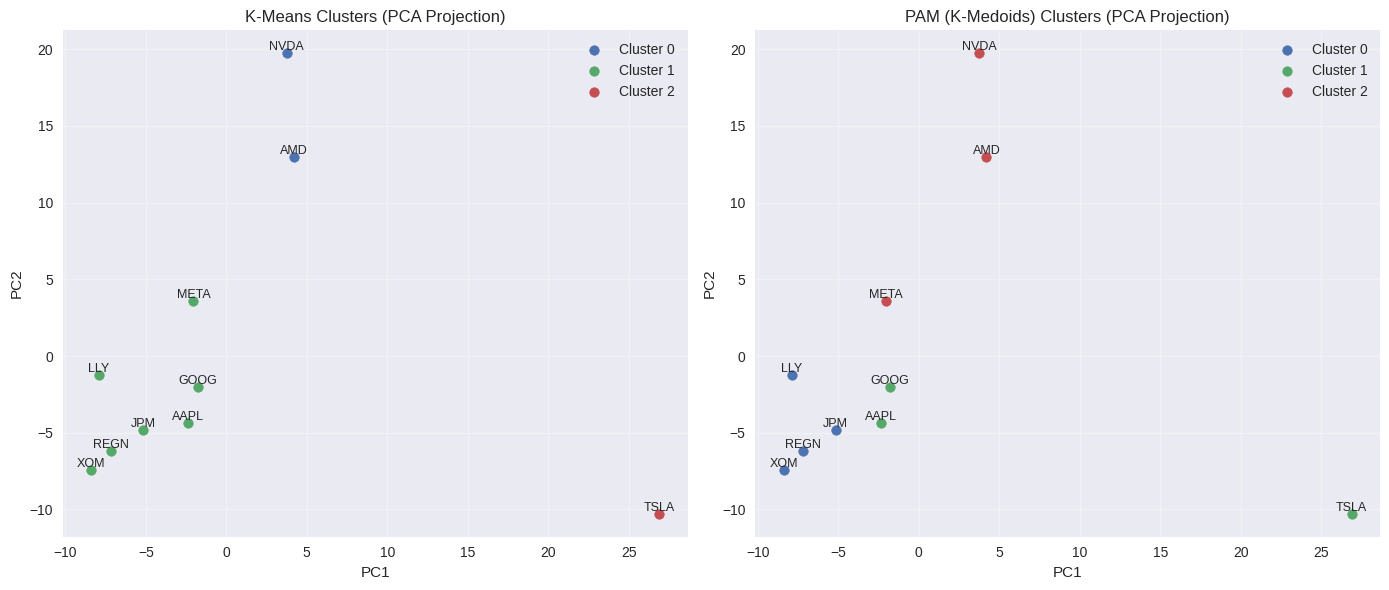

In [27]:
# ---------- PCA for 2D visualization ----------
pca = PCA(n_components=2)
coords_2d = pca.fit_transform(X_scaled)   # shape: (n_assets, 2)

plt.figure(figsize=(14, 6))

# --- Left: K-Means ---
plt.subplot(1, 2, 1)
for cl in range(n_clusters):
    idx = labels_kmeans == cl
    plt.scatter(coords_2d[idx, 0], coords_2d[idx, 1], label=f"Cluster {cl}")
    # Label assets
    for i in np.where(idx)[0]:
        plt.text(coords_2d[i, 0], coords_2d[i, 1], asset_names[i],
                 fontsize=9, ha='center', va='bottom')

plt.title("K-Means Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(alpha=0.3)

# --- Right: PAM / K-Medoids ---
plt.subplot(1, 2, 2)
for cl in range(n_clusters):
    idx = labels_pam == cl
    plt.scatter(coords_2d[idx, 0], coords_2d[idx, 1], label=f"Cluster {cl}")
    for i in np.where(idx)[0]:
        plt.text(coords_2d[i, 0], coords_2d[i, 1], asset_names[i],
                 fontsize=9, ha='center', va='bottom')

plt.title("PAM (K-Medoids) Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


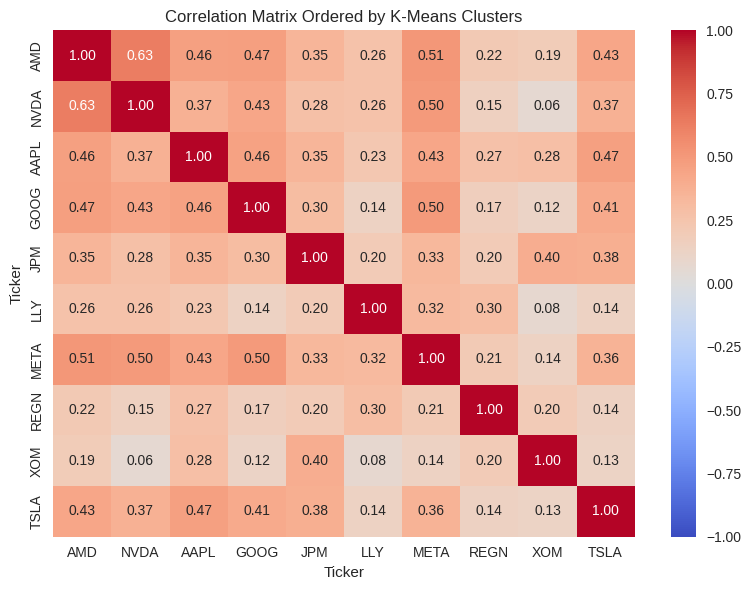

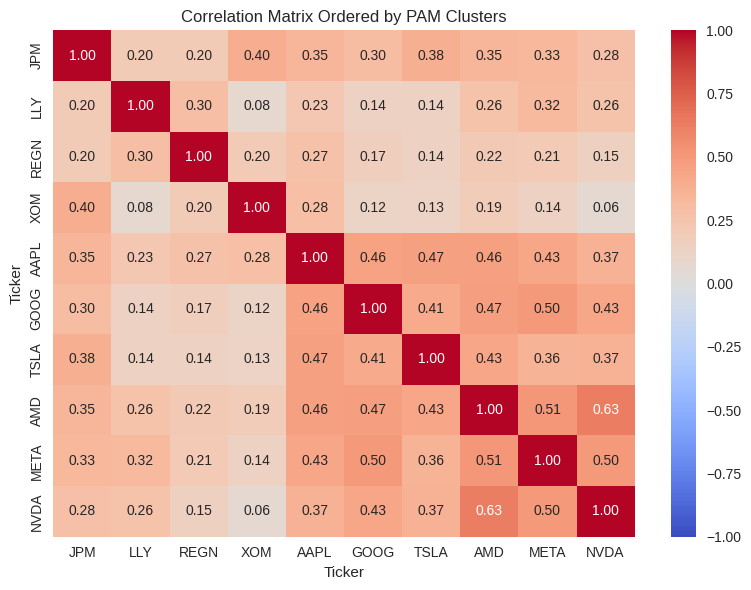

In [28]:
import seaborn as sns

# Base correlation matrix
corr = daily_returns.corr()

def plot_clustered_corr(corr, labels, title):
    # Order assets by cluster label
    order = np.argsort(labels)
    corr_reordered = corr.iloc[order, order]
    tickers_ordered = corr_reordered.index

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_reordered, annot=True, fmt=".2f",
                xticklabels=tickers_ordered,
                yticklabels=tickers_ordered,
                cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# K-Means clustered correlation
plot_clustered_corr(corr, labels_kmeans,
                    "Correlation Matrix Ordered by K-Means Clusters")

# PAM clustered correlation
plot_clustered_corr(corr, labels_pam,
                    "Correlation Matrix Ordered by PAM Clusters")


Improvements to baseline MVO using backtesting

In [29]:
# Split data
fit_end    = "2024-12-31"
val_start  = "2025-01-01"
val_end    = "2025-06-30"

prices_fit = df_data.loc[:fit_end]
prices_val = df_data.loc[val_start:val_end]

rets_fit = np.log(prices_fit / prices_fit.shift(1)).dropna()
rets_val = np.log(prices_val / prices_val.shift(1)).dropna()

mu_fit = rets_fit.mean().values
Sigma_fit = rets_fit.cov().values

lambda_grid = [1.0, 3.0, 5.0, 10.0]
results = []

for lam in lambda_grid:
    w_lam = solve_mvo(mu_fit, Sigma_fit, lambda_risk=lam, w_max=0.15)
    # Performance on validation period
    port_rets_val = rets_val @ pd.Series(w_lam, index=tickers)
    ann_ret_val = port_rets_val.mean() * ann_factor
    ann_vol_val = port_rets_val.std(ddof=1) * np.sqrt(ann_factor)
    sharpe_val  = ann_ret_val / ann_vol_val
    results.append({"lambda": lam, "AnnRet": ann_ret_val,
                    "AnnVol": ann_vol_val, "Sharpe": sharpe_val})

results_df = pd.DataFrame(results)
print(results_df)

# Choose best lambda by Sharpe on validation period
best_row = results_df.loc[results_df["Sharpe"].idxmax()]
best_lambda = best_row["lambda"]
print("\nBest lambda based on validation Sharpe:", best_lambda)

# Refit MVO on full training window using best lambda
w_bt = solve_mvo(mu, Sigma, lambda_risk=best_lambda, w_max=0.15)
w_bt_series = pd.Series(w_bt, index=tickers)

# In-sample performance (full training window)
port_rets_bt = daily_returns @ w_bt_series
ann_ret_bt  = port_rets_bt.mean() * ann_factor
ann_vol_bt  = port_rets_bt.std(ddof=1) * np.sqrt(ann_factor)
sharpe_bt   = ann_ret_bt / ann_vol_bt

print("\nBacktesting-tuned MVO weights:")
print(w_bt_series.round(4))

print("\nIn-sample performance (backtesting-tuned MVO):")
print(f"Ann. return:   {ann_ret_bt:.2%}")
print(f"Ann. vol:      {ann_vol_bt:.2%}")
print(f"Sharpe:        {sharpe_bt:.2f}")


   lambda    AnnRet    AnnVol    Sharpe
0     1.0 -0.136992  0.302517 -0.452840
1     3.0 -0.159267  0.304543 -0.522972
2     5.0 -0.068455  0.326485 -0.209672
3    10.0 -0.087429  0.338085 -0.258602

Best lambda based on validation Sharpe: 5.0

Backtesting-tuned MVO weights:
AAPL    0.10
NVDA    0.00
TSLA    0.15
XOM     0.15
REGN    0.15
LLY     0.15
JPM     0.15
META    0.00
GOOG    0.00
AMD     0.15
dtype: float64

In-sample performance (backtesting-tuned MVO):
Ann. return:   6.61%
Ann. vol:      24.19%
Sharpe:        0.27


We try all enhancements together on a single portfolio optimization case.

Our pipeline:
1. Denoising
2. Clustering
3. Backtesting

We propose this pipeline because we will clean the covariance matrix, control for correlation concentration, and finally select the optimal lambda for optimization and validation of results.

### Step 4

3 metrics to optimize for:

1. return
2. sharpe ratio
3. variance

[*********************100%***********************]  10 of 10 completed

Train period: 2024-01-03 00:00:00 to 2025-06-30 00:00:00
Test period: 2025-07-01 00:00:00 to 2025-07-30 00:00:00
Train days: 373 | Test days: 21

PAM cluster assignments:


,Ticker,PAM_Cluster
3,XOM,0
4,REGN,0
7,META,0
9,AMD,0
0,AAPL,1
2,TSLA,1
8,GOOG,1
1,NVDA,2
5,LLY,2
6,JPM,2


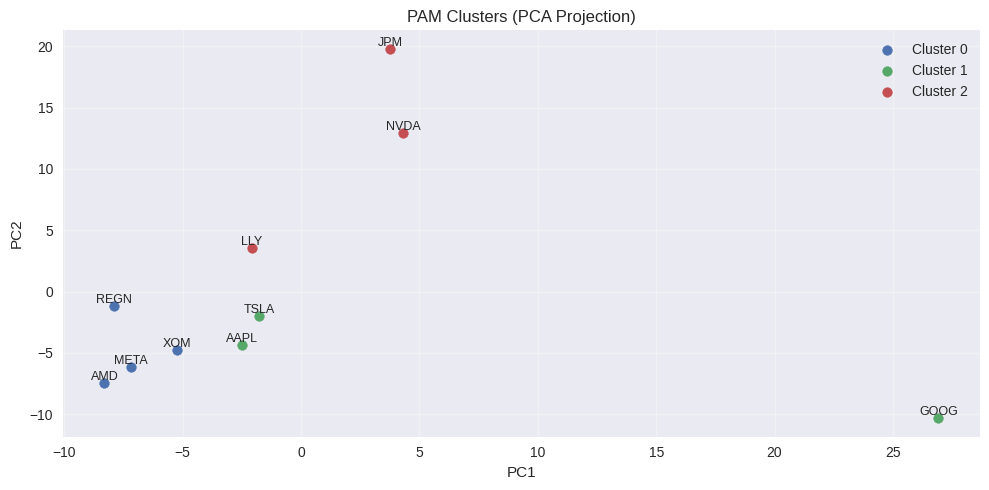

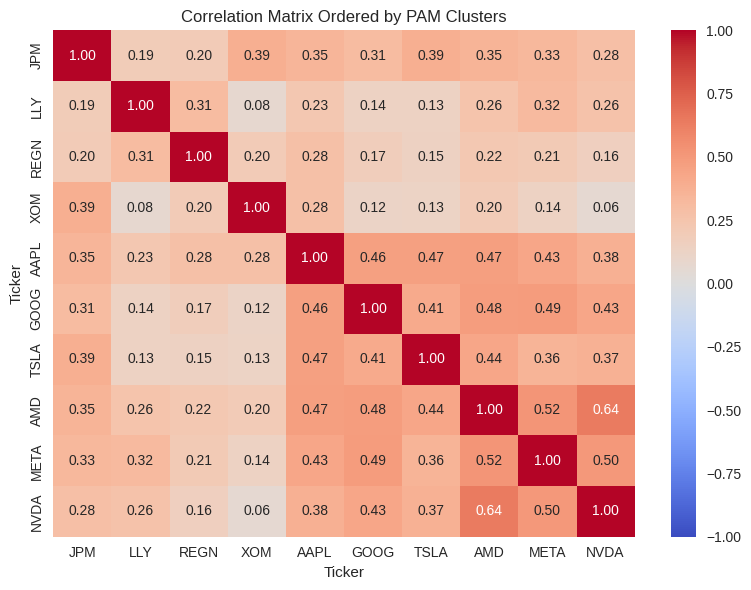


Portfolio weights by method:


,Baseline (Sample Σ),LW only,PAM only,LW + PAM
Ticker,,,,
AAPL,0.099960,0.099953,1.500001e-01,1.500001e-01
NVDA,0.000004,0.000005,3.334136e-02,3.334044e-02
TSLA,0.150005,0.150005,1.500001e-01,1.500001e-01
XOM,0.150005,0.150005,1.499998e-01,1.500000e-01
REGN,0.150005,0.150005,8.297530e-02,9.072996e-02
LLY,0.150004,0.150005,1.499960e-01,1.499965e-01
JPM,0.150004,0.150006,1.499960e-01,1.499964e-01
META,0.000005,0.000005,-5.984095e-08,1.093703e-08
GOOG,0.000004,0.000005,3.333312e-02,3.333315e-02


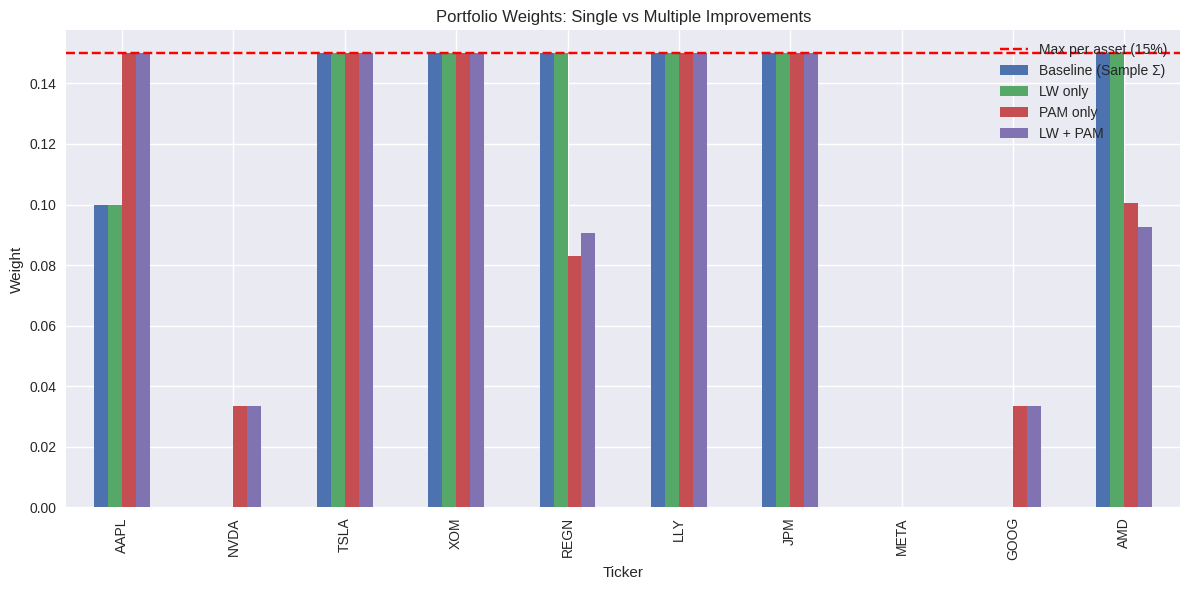


Performance summary (IS vs OOS):


,Method,Ann_Return_IS,Ann_Vol_IS,Sharpe_IS,MaxDD_IS,Ann_Return_OOS,Ann_Vol_OOS,Sharpe_OOS,MaxDD_OOS
0,Baseline (Sample Σ),0.378155,0.221529,1.707025,-0.219600,0.440808,0.100473,4.387343,-0.010769
1,LW only,0.378157,0.221530,1.707030,-0.219600,0.440814,0.100473,4.387380,-0.010769
2,PAM only,0.382291,0.241613,1.582243,-0.242236,0.549867,0.103919,5.291290,-0.013117
3,LW + PAM,0.383744,0.242237,1.584166,-0.242714,0.544260,0.104768,5.194921,-0.013284


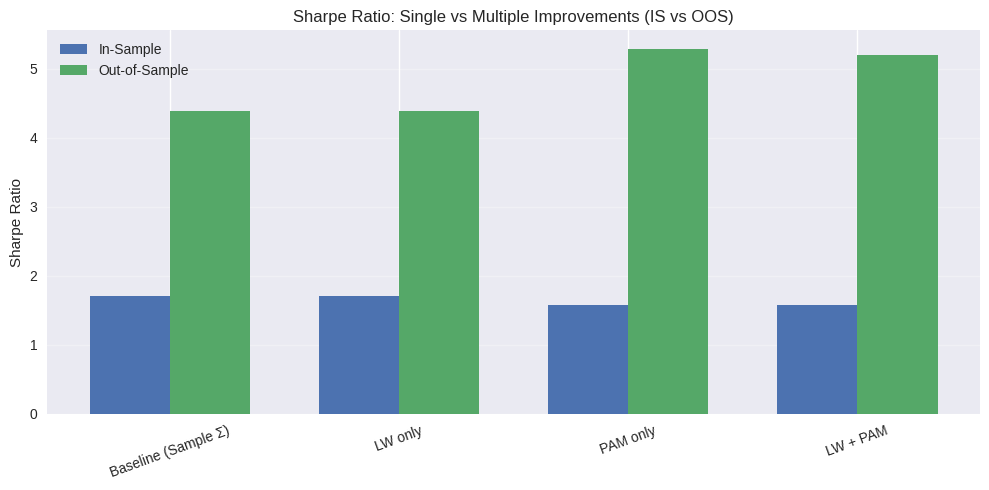

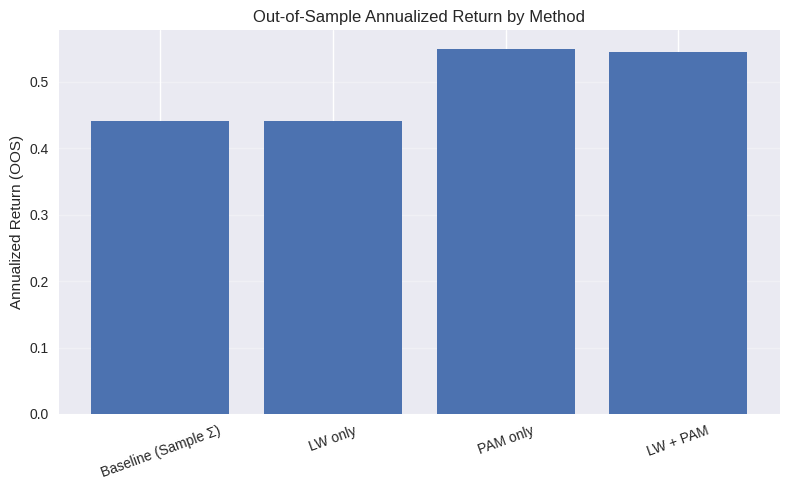

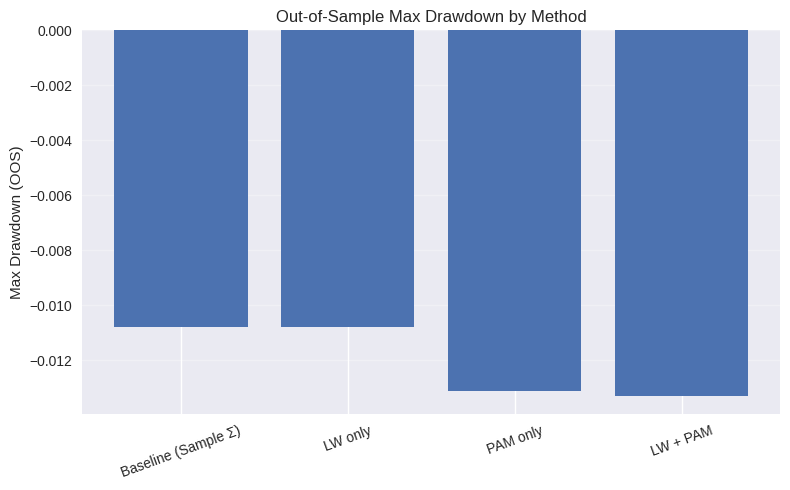

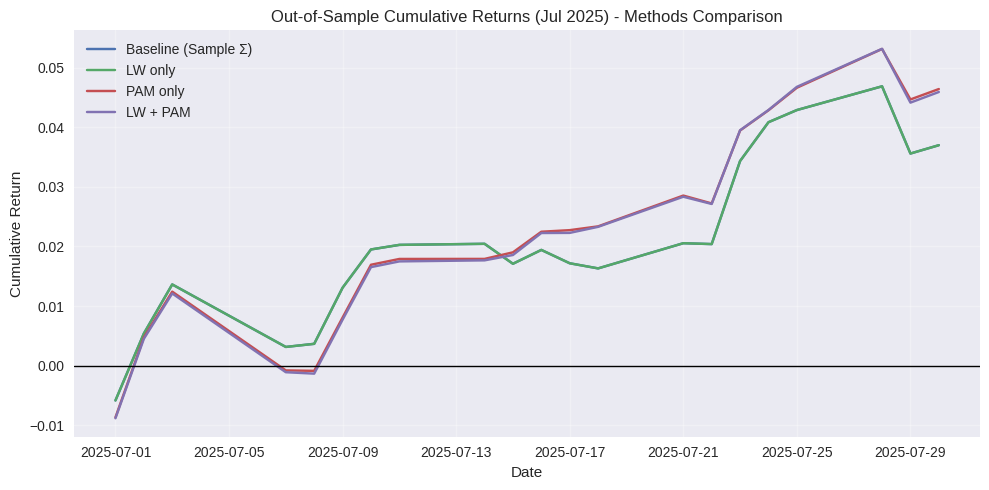

In [45]:
import yfinance as yf
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.covariance import LedoitWolf
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

plt.rcParams["figure.figsize"] = (10, 5)

# ---------------------------------------------------
# 0. PARAMETERS
# ---------------------------------------------------
tickers = ["AAPL", "NVDA", "TSLA", "XOM", "REGN", "LLY", "JPM", "META", "GOOG", "AMD"]
ann_factor = 252
lambda_risk = 5.0  # or use your best_lambda from sensitivity analysis
w_max = 0.15
n_clusters = 3     # for PAM clustering

# ---------------------------------------------------
# 1. DATA: Prices and returns
# ---------------------------------------------------
df_prices = yf.download(
    tickers,
    start="2024-01-01",
    end="2025-07-31",
    auto_adjust=False
)["Close"]

returns = df_prices.pct_change().dropna()

# Train (in-sample): Jan 1 2024 – Jun 30 2025
train_mask = returns.index <= "2025-06-30"
test_mask  = returns.index >  "2025-06-30"

returns_train = returns.loc[train_mask]
returns_test  = returns.loc[test_mask]

print("Train period:", returns_train.index.min(), "to", returns_train.index.max())
print("Test period:",  returns_test.index.min(),  "to", returns_test.index.max())
print("Train days:", len(returns_train), "| Test days:", len(returns_test))

# ---------------------------------------------------
# 2. Basic helpers: MVO, stats, max drawdown
# ---------------------------------------------------
def solve_mvo(mu, Sigma, lambda_risk, w_max=0.15):
    n = len(mu)
    w = cp.Variable(n)
    objective = cp.Maximize(mu @ w - lambda_risk * cp.quad_form(w, Sigma))
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        w <= w_max
    ]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)
    return np.array(w.value).flatten()

def solve_clustered_mvo(mu, Sigma, labels, lambda_risk, w_max=0.15):
    """
    MVO with:
    - Long-only, w <= w_max
    - Equal cluster weights: sum_{i in cluster k} w_i = 1 / K
    """
    n = len(mu)
    unique_clusters = np.unique(labels)
    K = len(unique_clusters)

    w = cp.Variable(n)
    objective = cp.Maximize(mu @ w - lambda_risk * cp.quad_form(w, Sigma))
    constraints = [cp.sum(w) == 1, w >= 0, w <= w_max]

    for c in unique_clusters:
        idx = np.where(labels == c)[0]
        constraints.append(cp.sum(w[idx]) == 1.0 / K)

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)
    return np.array(w.value).flatten()

def max_drawdown(return_series):
    """
    return_series: 1D numpy array or pandas Series of daily returns
    """
    cum = (1 + pd.Series(return_series)).cumprod()
    peak = np.maximum.accumulate(cum)
    dd = (cum - peak) / peak
    return dd.min()

def portfolio_stats(returns_mat, w):
    """
    returns_mat: 2D numpy array (T x n)
    w: 1D numpy array (n,)
    """
    port_rets = returns_mat @ w
    ann_ret = port_rets.mean() * ann_factor
    ann_vol = port_rets.std(ddof=1) * np.sqrt(ann_factor)
    sharpe = ann_ret / ann_vol
    mdd = max_drawdown(port_rets)
    return ann_ret, ann_vol, sharpe, mdd, port_rets

# ---------------------------------------------------
# 3. Moments and Ledoit–Wolf Denoising (Train)
# ---------------------------------------------------
mu_train = returns_train.mean().values
Sigma_sample = np.cov(returns_train.values, rowvar=False)

lw = LedoitWolf().fit(returns_train.values)
Sigma_lw = lw.covariance_

# ---------------------------------------------------
# 4. PAM Clustering on Train
# ---------------------------------------------------
X_assets = returns_train.values.T        # shape: (n_assets, T)
asset_names = np.array(tickers)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_assets)

pam = KMedoids(n_clusters=n_clusters, metric='euclidean', random_state=42)
labels_pam = pam.fit_predict(X_scaled)

cluster_df = pd.DataFrame({
    "Ticker": asset_names,
    "PAM_Cluster": labels_pam
}).sort_values("PAM_Cluster")

print("\nPAM cluster assignments:")
display(cluster_df)

# --- Optional visuals for report ---
# PCA cluster plot
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
coords_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 5))
for cl in range(n_clusters):
    idx = labels_pam == cl
    plt.scatter(coords_2d[idx, 0], coords_2d[idx, 1], label=f"Cluster {cl}")
    for i in np.where(idx)[0]:
        plt.text(coords_2d[i, 0], coords_2d[i, 1], asset_names[i],
                 fontsize=9, ha='center', va='bottom')
plt.title("PAM Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Clustered correlation heatmap
corr_train = returns_train.corr()
order = np.argsort(labels_pam)
corr_reordered = corr_train.iloc[order, order]
tickers_ordered = corr_reordered.index

plt.figure(figsize=(8, 6))
sns.heatmap(corr_reordered, annot=True, fmt=".2f",
            xticklabels=tickers_ordered,
            yticklabels=tickers_ordered,
            cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix Ordered by PAM Clusters")
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 5. Portfolios: Single vs Multiple Improvements
# ---------------------------------------------------
# 1) Baseline: sample covariance, no clustering
w_baseline = solve_mvo(mu_train, Sigma_sample, lambda_risk=lambda_risk, w_max=w_max)

# 2) LW only: denoising, no clustering
w_lw = solve_mvo(mu_train, Sigma_lw, lambda_risk=lambda_risk, w_max=w_max)

# 3) PAM only: clustering constraint, sample covariance
w_pam = solve_clustered_mvo(mu_train, Sigma_sample, labels_pam,
                            lambda_risk=lambda_risk, w_max=w_max)

# 4) LW + PAM: multiple improvements together
w_lw_pam = solve_clustered_mvo(mu_train, Sigma_lw, labels_pam,
                               lambda_risk=lambda_risk, w_max=w_max)

weights_df = pd.DataFrame({
    "Ticker": tickers,
    "Baseline (Sample Σ)": w_baseline,
    "LW only": w_lw,
    "PAM only": w_pam,
    "LW + PAM": w_lw_pam
}).set_index("Ticker")

print("\nPortfolio weights by method:")
display(weights_df)

# Visual: weight comparison
weights_df.plot(kind="bar", figsize=(12, 6))
plt.title("Portfolio Weights: Single vs Multiple Improvements")
plt.ylabel("Weight")
plt.axhline(w_max, color="red", linestyle="--", label="Max per asset (15%)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 6. In-Sample & Test-Period Performance (Return, Sharpe, Max DD)
# ---------------------------------------------------
methods = {
    "Baseline (Sample Σ)": w_baseline,
    "LW only": w_lw,
    "PAM only": w_pam,
    "LW + PAM": w_lw_pam
}

rows = []

for name, w in methods.items():
    # In-sample stats
    ann_ret_is, ann_vol_is, sharpe_is, mdd_is, rets_is = portfolio_stats(returns_train.values, w)

    # Out-of-sample stats (test period)
    if len(returns_test) > 0:
        ann_ret_oos, ann_vol_oos, sharpe_oos, mdd_oos, rets_oos = portfolio_stats(returns_test.values, w)
    else:
        ann_ret_oos = ann_vol_oos = sharpe_oos = mdd_oos = np.nan
        rets_oos = np.array([])

    rows.append({
        "Method": name,
        "Ann_Return_IS": ann_ret_is,
        "Ann_Vol_IS": ann_vol_is,
        "Sharpe_IS": sharpe_is,
        "MaxDD_IS": mdd_is,
        "Ann_Return_OOS": ann_ret_oos,
        "Ann_Vol_OOS": ann_vol_oos,
        "Sharpe_OOS": sharpe_oos,
        "MaxDD_OOS": mdd_oos
    })

perf_df = pd.DataFrame(rows)
print("\nPerformance summary (IS vs OOS):")
display(perf_df)

# ---------------------------------------------------
# 7. Step 4 Visuals: Comparing Single vs Multiple Improvements
# ---------------------------------------------------
# A) Sharpe ratio IS vs OOS
x = np.arange(len(perf_df))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, perf_df["Sharpe_IS"], width, label="In-Sample")
plt.bar(x + width/2, perf_df["Sharpe_OOS"], width, label="Out-of-Sample")
plt.xticks(x, perf_df["Method"], rotation=20)
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio: Single vs Multiple Improvements (IS vs OOS)")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# B) Out-of-sample annualized return
plt.figure(figsize=(8, 5))
plt.bar(perf_df["Method"], perf_df["Ann_Return_OOS"])
plt.xticks(rotation=20)
plt.ylabel("Annualized Return (OOS)")
plt.title("Out-of-Sample Annualized Return by Method")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# C) Out-of-sample maximum drawdown (note: more negative = worse)
plt.figure(figsize=(8, 5))
plt.bar(perf_df["Method"], perf_df["MaxDD_OOS"])
plt.xticks(rotation=20)
plt.ylabel("Max Drawdown (OOS)")
plt.title("Out-of-Sample Max Drawdown by Method")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# D) Cumulative returns in test period
plt.figure(figsize=(10, 5))

for name, w in methods.items():
    if len(returns_test) == 0:
        continue
    _, _, _, _, rets_oos = portfolio_stats(returns_test.values, w)
    cum_rets = (1 + pd.Series(rets_oos, index=returns_test.index)).cumprod() - 1
    plt.plot(cum_rets.index, cum_rets.values, label=name)

plt.axhline(0, color="black", linewidth=1)
plt.title("Out-of-Sample Cumulative Returns (Jul 2025) - Methods Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### Step 5

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ann_factor = 252

def max_drawdown(return_series):
    """
    return_series: 1D numpy array or pandas Series of daily returns
    """
    cum = (1 + pd.Series(return_series)).cumprod()
    peak = np.maximum.accumulate(cum)
    dd = (cum - peak) / peak
    return dd.min()

def portfolio_stats(returns_mat, w):
    """
    returns_mat: 2D numpy array (T x n)
    w: 1D numpy array (n,)
    """
    port_rets = returns_mat @ w
    ann_ret = port_rets.mean() * ann_factor
    ann_vol = port_rets.std(ddof=1) * np.sqrt(ann_factor)
    sharpe = ann_ret / ann_vol
    mdd = max_drawdown(port_rets)
    return ann_ret, ann_vol, sharpe, mdd, port_rets


In [47]:
import cvxpy as cp
from sklearn.covariance import LedoitWolf
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

lambda_risk = 5.0   # or your best_lambda
w_max = 0.15

# moments
mu_train = returns_train.mean().values
Sigma_sample = np.cov(returns_train.values, rowvar=False)

# Ledoit–Wolf covariance
lw = LedoitWolf().fit(returns_train.values)
Sigma_lw = lw.covariance_

def solve_mvo(mu, Sigma, lambda_risk, w_max=0.15):
    n = len(mu)
    w = cp.Variable(n)
    objective = cp.Maximize(mu @ w - lambda_risk * cp.quad_form(w, Sigma))
    constraints = [cp.sum(w) == 1, w >= 0, w <= w_max]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)
    return np.array(w.value).flatten()

def solve_clustered_mvo(mu, Sigma, labels, lambda_risk, w_max=0.15):
    n = len(mu)
    unique_clusters = np.unique(labels)
    K = len(unique_clusters)
    w = cp.Variable(n)
    objective = cp.Maximize(mu @ w - lambda_risk * cp.quad_form(w, Sigma))
    constraints = [cp.sum(w) == 1, w >= 0, w <= w_max]
    for c in unique_clusters:
        idx = np.where(labels == c)[0]
        constraints.append(cp.sum(w[idx]) == 1.0 / K)
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)
    return np.array(w.value).flatten()

# PAM clustering
X_assets = returns_train.values.T
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_assets)

pam = KMedoids(n_clusters=3, metric="euclidean", random_state=42)
labels_pam = pam.fit_predict(X_scaled)

# step 1 portfolio (standard MVO)
w_baseline = solve_mvo(mu_train, Sigma_sample, lambda_risk=lambda_risk, w_max=w_max)

# enhanced portfolio (LW + PAM)
w_lw_pam = solve_clustered_mvo(mu_train, Sigma_lw, labels_pam,
                               lambda_risk=lambda_risk, w_max=w_max)


In [48]:
methods_step5 = {
    "Baseline (Step 1: Sample Σ MVO)": w_baseline,
    "Enhanced (Step 4: LW + PAM)": w_lw_pam
}

rows = []

for name, w in methods_step5.items():
    # In-sample stats
    ann_ret_is, ann_vol_is, sharpe_is, mdd_is, rets_is = portfolio_stats(returns_train.values, w)

    # Out-of-sample stats (test period: Jul 2025)
    if len(returns_test) > 0:
        ann_ret_oos, ann_vol_oos, sharpe_oos, mdd_oos, rets_oos = portfolio_stats(returns_test.values, w)
    else:
        ann_ret_oos = ann_vol_oos = sharpe_oos = mdd_oos = np.nan
        rets_oos = np.array([])

    rows.append({
        "Method": name,
        "Ann_Return_IS": ann_ret_is,
        "Ann_Vol_IS": ann_vol_is,
        "Sharpe_IS": sharpe_is,
        "MaxDD_IS": mdd_is,
        "Ann_Return_OOS": ann_ret_oos,
        "Ann_Vol_OOS": ann_vol_oos,
        "Sharpe_OOS": sharpe_oos,
        "MaxDD_OOS": mdd_oos
    })

step5_df = pd.DataFrame(rows)
display(step5_df)


,Method,Ann_Return_IS,Ann_Vol_IS,Sharpe_IS,MaxDD_IS,Ann_Return_OOS,Ann_Vol_OOS,Sharpe_OOS,MaxDD_OOS
0,Baseline (Step 1: Sample Σ MVO),0.378155,0.221529,1.707025,-0.219600,0.440808,0.100473,4.387343,-0.010769
1,Enhanced (Step 4: LW + PAM),0.383744,0.242237,1.584166,-0.242714,0.544260,0.104768,5.194921,-0.013284


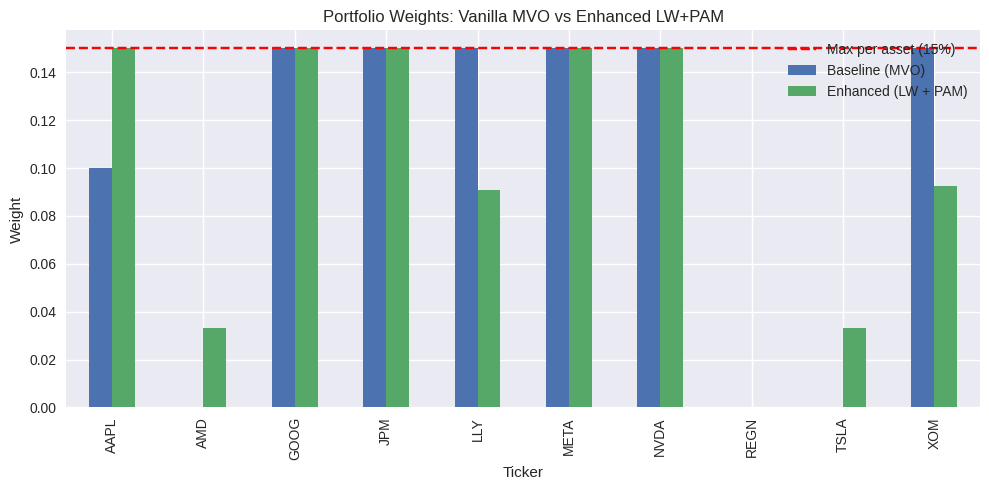

In [58]:
weights_step5 = pd.DataFrame({
    "Ticker": returns_train.columns,
    "Baseline (MVO)": methods_step5["Baseline (Step 1: Sample Σ MVO)"],
    "Enhanced (LW + PAM)": methods_step5["Enhanced (Step 4: LW + PAM)"]
}).set_index("Ticker")

weights_step5.plot(kind="bar", figsize=(10, 5))
plt.title("Portfolio Weights: Vanilla MVO vs Enhanced LW+PAM")
plt.ylabel("Weight")
plt.axhline(0.15, color="red", linestyle="--", label="Max per asset (15%)")
plt.legend()
plt.tight_layout()
plt.show()


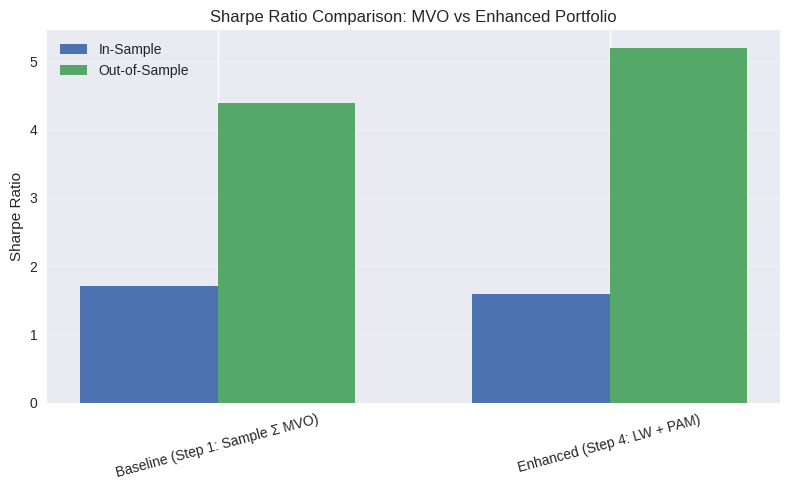

In [59]:
x = np.arange(len(step5_df))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, step5_df["Sharpe_IS"], width, label="In-Sample")
plt.bar(x + width/2, step5_df["Sharpe_OOS"], width, label="Out-of-Sample")
plt.xticks(x, step5_df["Method"], rotation=15)
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio Comparison: MVO vs Enhanced Portfolio")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


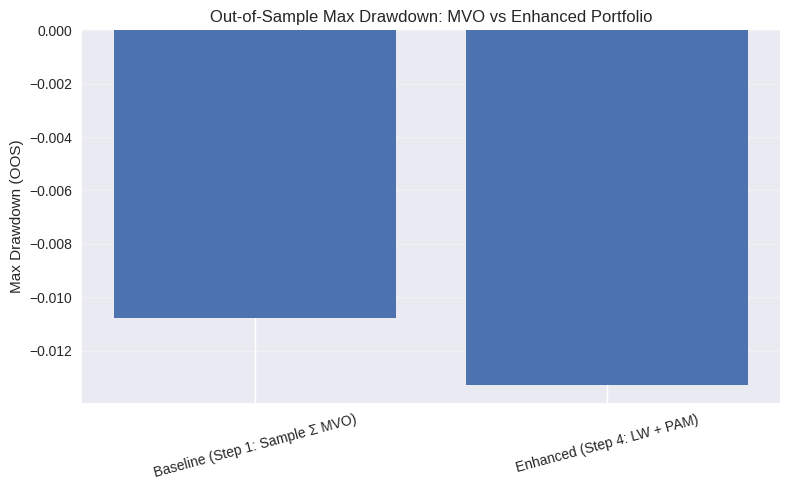

In [60]:
plt.figure(figsize=(8, 5))
plt.bar(step5_df["Method"], step5_df["MaxDD_OOS"])
plt.xticks(rotation=15)
plt.ylabel("Max Drawdown (OOS)")
plt.title("Out-of-Sample Max Drawdown: MVO vs Enhanced Portfolio")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


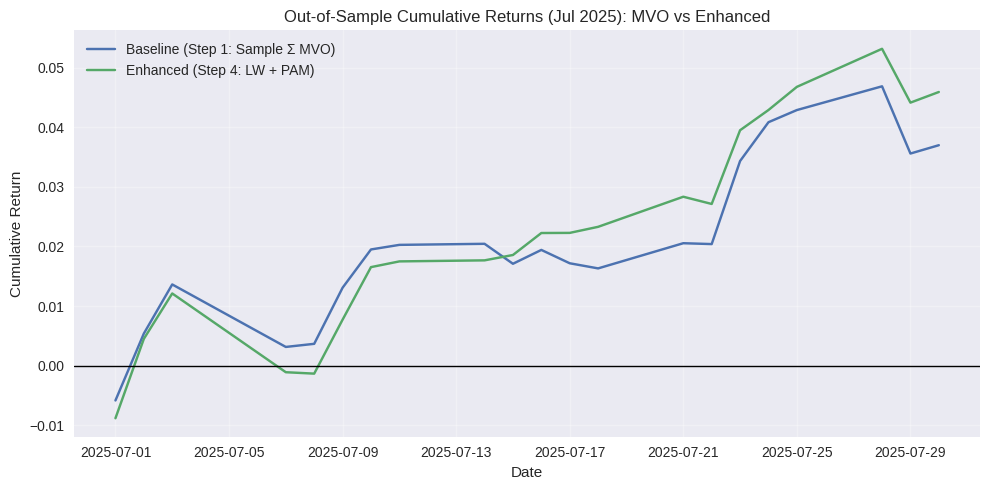

In [61]:
plt.figure(figsize=(10, 5))

for name, w in methods_step5.items():
    if len(returns_test) == 0:
        continue
    _, _, _, _, rets_oos = portfolio_stats(returns_test.values, w)
    cum_rets = (1 + pd.Series(rets_oos, index=returns_test.index)).cumprod() - 1
    plt.plot(cum_rets.index, cum_rets.values, label=name)

plt.axhline(0, color="black", linewidth=1)
plt.title("Out-of-Sample Cumulative Returns (Jul 2025): MVO vs Enhanced")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
